<a href="https://colab.research.google.com/github/mairapineda/Deep_Learning/blob/main/P2_T2_2_ClasificaciondeSentimientos_ML_VS_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#¿Se puede predecir la depresión?

¡Descubrir si una persona está deprimida por el uso de palabras en las redes sociales definitivamente puede ayudar en la cura!

#Análisis Sentimental

#Machine Learning classic (LogisticRegression)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

##P0.descargando librerias

---
*   https://stackabuse.com/python-for-nlp-introduction-to-the-pattern-library/




In [2]:
!pip install pyprind

In [3]:
import nltk
nltk.download('stopwords') #Descargamos la lista de StopWord (pronombres, artículos, condicionales, demostrativos, adverbios de tiempo y lugar)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
!pip install pattern  #libreria para PLN (Tokenización, derivación, etiquetado de POS, análisis de sentimientos, etc)

     |████████████████████████████████| 22.2 MB 1.6 MB/s 
     |████████████████████████████████| 87 kB 6.4 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 5.6 MB 13.9 MB/s 
     |████████████████████████████████| 5.6 MB 27.2 MB/s 
     |████████████████████████████████| 419 kB 39.4 MB/s 
     |████████████████████████████████| 104 kB 35.0 MB/s 
     |████████████████████████████████| 4.0 MB 29.9 MB/s 
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332721 sha256=efbfdf7b293e1dc218d37cddd9218a74b0a336589c51a0603a36d93b6e31611e
  Stored in directory: /root/.cache/pip/wheels/8d/1f/4e/9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99970 sha256=fb0a3496d766c0db003b314bfc5bd7a9c38d611f208a57514ea0aceb324436a0
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4
  

##P1.Importando librerias

###P1.1 Genericas

In [5]:
import urllib.request
import numpy as np
import pandas as pd 
import os
import time
import sys
from zipfile import ZipFile       #para descomprimir ZIP
#-----librerias para trabajar PLN
import nltk
#from pattern.es import lemma
from nltk import word_tokenize
from nltk.corpus import stopwords

#----librerias para normalización de textos
import re
from unicodedata import normalize

###P1.2 Machine Learning

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#CountVectorizer proporcionado por la biblioteca scikit-learn para vectorizar oraciones.
from sklearn.feature_extraction.text import CountVectorizer

##P2. descargando DataSet

In [8]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d segundos transcurrido" %
                    (percent, progress_size / (1024.**2), speed, duration))
    sys.stdout.flush()

url_github_Model='https://raw.githubusercontent.com/mairapineda/Deep_Learning/main/Database/sentiment_tweets3.csv'
urllib.request.urlretrieve(url_github_Model,
                           'DataSetOpiniones.csv', 
                           reporthook)

100% | 1 MB | 3.42 MB/s | 0 segundos transcurrido

('DataSetOpiniones.csv', <http.client.HTTPMessage at 0x7f856c43b290>)

#Sentimental Analysis for Tweets
El Análisis Sentimental puede ser muy útil para descubrir la depresión y curarla antes de que alguien se meta en serios problemas.

¿La persona tiene depresión? 0 para NO y 1 significa SÍ

###P3.2 carga los CSV en Dataframe

In [10]:
filepath_dict = {'tweets':   '/content/DataSetOpiniones.csv'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'])
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head(10)

,sentence,label,source
106,just had a real good moment. i missssssssss hi...,0,tweets
217,is reading manga http://plurk.com/p/mzp1e,0,tweets
220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,tweets
288,@lapcat Need to send 'em to my accountant tomo...,0,tweets
540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,tweets
624,so sleepy. good times tonight though,0,tweets
701,"@SilkCharm re: #nbn as someone already said, d...",0,tweets
808,23 or 24ï¿½C possible today. Nice,0,tweets
1193,nite twitterville workout in the am -ciao,0,tweets
1324,"@daNanner Night, darlin'! Sweet dreams to you",0,tweets


##P4. conociendo la data (BagWord)

In [39]:
print('RowsXcolums-->',df.shape)
print('tweets-->',sum(df['source'] == 'tweets'))


RowsXcolums--> (10314, 3)
tweets--> 10314


###P4.1 usando CountVectorizer (ejemplo)

---

CountVectorizer proporcionado por la biblioteca scikit-learn  realiza la tokenización que separa las oraciones en un conjunto de tokens ordenado por vocabulario. Además, elimina la puntuación y los caracteres especiales y puede aplicar otro preprocesamiento a cada palabra

In [41]:
#obtener las palabras que aparecen de acuerdo con el Orden del vocabulario
oraciones = ['My doggy is so cute', 'depression: im always here for u, darling']
vectorizer = CountVectorizer(min_df=0, lowercase=True,stop_words=stopwords.words('english'))   
     
vectorizer.fit(oraciones)

CountVectorizer(min_df=0,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [42]:
vectorizer.get_feature_names_out()

array(['always', 'cute', 'darling', 'depression', 'doggy', 'im'],
      dtype=object)

In [43]:
vectorizer.vocabulary_

{'always': 0, 'cute': 1, 'darling': 2, 'depression': 3, 'doggy': 4, 'im': 5}

In [44]:
#bolsa de palabras (Cada documento se representa como un vector)
#vectorizer.transform(oraciones).toarray()
array=vectorizer.transform(oraciones)
print(array.toarray())

[[0 1 0 0 1 0]
 [1 0 1 1 0 1]]


###P4.2 usando CountVectorizer con datos de Sentimental Analysis for Tweets

In [45]:
df_tweet = df[df['source'] == 'tweets']
sentences = df_tweet['sentence'].values
y = df_tweet['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

###P4.3 generar BagWords 

---



In [46]:
#generamos los vectores de palabras (750x1681) registrosXtamaño del vocabulario
#vectorizer = CountVectorizer(min_df=0, lowercase=True,stop_words=stopwords.words('spanish'))   
vectorizer = CountVectorizer(min_df=0, lowercase=True)   
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
#print(X_train.toarray())

In [47]:
print(X_train.toarray())
X_train.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(7735, 18509)

##P5.modelo de ML (regresión logistica).

In [48]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Precisión:", score)

Precisión: 0.9941837921675067


###P5.1 evaluando modelo por cada set de datos

In [49]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)
    vectorizer = CountVectorizer(min_df=0, lowercase=True) 
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Precisión para datos {}: {:.4f}'.format(source, score))

Precisión para datos tweets: 0.9942


###P5.2 evaluando modelo con fulldata

In [50]:
sentences = df['sentence'].values
y = df['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer(min_df=0, lowercase=True)   
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
modeloPLNRegLog = LogisticRegression()
modeloPLNRegLog.fit(X_train, y_train)
score = modeloPLNRegLog.score(X_test, y_test)

print("Precisión:", score)

Precisión: 0.9941837921675067


In [51]:
print(X_train.toarray())
X_train.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(7735, 18509)

###P5.3 Salvando el modelo (serializando)

---
*   salvaremos el modelo y el vocabulario generado del bagWords
*   para ver metodos de exportación:
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/


In [52]:
import pickle

pickle.dump(modeloPLNRegLog, open( 'LogRegression_PLN_classSentimientos_model.sav', 'wb'))
#serializando el vocabulario
feature_list = vectorizer.get_feature_names_out()
pickle.dump(feature_list, open('vocabulary.pkl', 'wb'))

###P5.4 cargando el modelo (serializado)

In [53]:
#cargando el modelo
modeloPLNRegLogNew = pickle.load(open('LogRegression_PLN_classSentimientos_model.sav', 'rb'))
#cargando el vocabulario
vocabularyNew= pickle.load(open('vocabulary.pkl', 'rb'))
vectorizerNew = CountVectorizer(min_df=0, lowercase=True,vocabulary = vocabularyNew)  #creando un nuevo vectorizador con el vocabulario cargado
result = modeloPLNRegLogNew.score(X_test, y_test)   #probado con el test de entrenamiento a ver si funciona
print('Inferencia:%',result)

Inferencia:% 0.9941837921675067


###P5.5 Haciendo predicciones

In [54]:
oracion = ['I love spontaneous road trips']
X_prueba = vectorizerNew.transform(oracion)  #convertimos la oración al array del bagword

#print('vector:',X_prueba[0].toarray())
predict=modeloPLNRegLogNew.predict(X_prueba)
print(oracion,',The Sentiment is :',predict)


['I love spontaneous road trips'] ,The Sentiment is : [0]


#Deep Learning

---
Donde usaremos Las redes neuronales, o algunas veces llamadas redes neuronales artificiales (RNA)
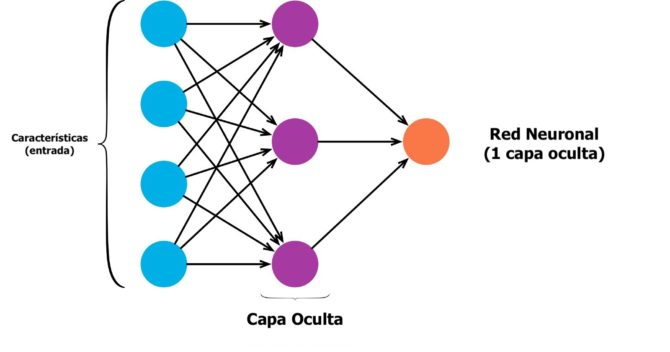


**Notas:**
*  la ultima capa es una sola neurona ya que el resultado es binario (1 o 0), pero si tiene varias categorías, debe usar varios neuronas para cada categoría.
*  Puede tener tantas capas ocultas como desee. De hecho, una red neuronal con más de una capa oculta se considera una red neuronal profunda.
*  el peso de cada neurona se calcula en el entrenamiento y comienza con la inicialización de los pesos con valores aleatorios y luego se entrenan con un método llamado backpropagation.
*   Esto se hace utilizando métodos de optimización como el descenso de gradiente para reducir el error entre la salida calculada y la deseada (también llamada salida objetivo)...el mejor es ADAM
*   Para calcular El error está determinado por una función de pérdida cuya pérdida queremos minimizar con el optimizador. en este tutorial solo necesitará la función de pérdida de entropía cruzada binaria que se usa para los problemas de clasificación binaria.


##Usando KERAS

---

Usaremos un modelo secuencial que es una pila lineal de capas, donde puede usar la gran variedad de capas disponibles en Keras. La capa más común es la capa Densa, que es su capa de red neuronal densamente conectada con todos los pesos y sesgos con los que ya está familiarizado

##P0.importando librerias

In [29]:
from keras.models import Sequential
from keras import layers

##P1.Creando modelo secuencial

---
*  1° capa tendremos doble capa 
*   - 1° # dimensiones (18509 columnas)
*   - 2° 10 neuronas
*   - 3° 10 neuronas
*   usaremos como activación RELU/Sigmoidal

In [55]:
input_dim = X_train.shape[1]  # Numero de características (neuronas de entrada)
print("neuronas de entrada (columnas del vector de entrenamiento):",input_dim)

neuronas de entrada (columnas del vector de entrenamiento): 18509


In [56]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) #1° # dimensiones (4085 columnas), 2° 10 neuronas
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))  #que pasa si agregamos otra capa (mejorara?)
model.add(layers.Dense(1, activation='sigmoid'))

##P2. compilando el modelo.

---
Antes de que pueda comenzar con el entrenamiento del modelo, debe configurar el proceso de aprendizaje. Esto se hace con el método .compile().
*   Este método especifica el optimizador y la función de pérdida
*   agregamos una lista de métricas que luego se pueden usar para la evaluación (accuracy o Loss)


In [57]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                185100    
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 185,221
Trainable params: 185,221
Non-trainable params: 0
_________________________________________________________________


##P3. entrenamos el modelo

In [34]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/500
774/774 [==============================] - 12s 15ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0273 - val_accuracy: 0.9942
Epoch 2/500
774/774 [==============================] - 7s 9ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0315 - val_accuracy: 0.9926
Epoch 3/500
774/774 [==============================] - 7s 9ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0284 - val_accuracy: 0.9934
Epoch 4/500
774/774 [==============================] - 7s 9ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0334 - val_accuracy: 0.9938
Epoch 5/500
774/774 [==============================] - 7s 9ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0453 - val_accuracy: 0.9907
Epoch 6/500
774/774 [==============================] - 7s 9ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0615 - val_accuracy: 0.9891
Epoch 7/500
774/774 [==============================] - 7s 10ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.0580 - val_accuracy: 0.9

##P4. viendo grafica de entrenamiento

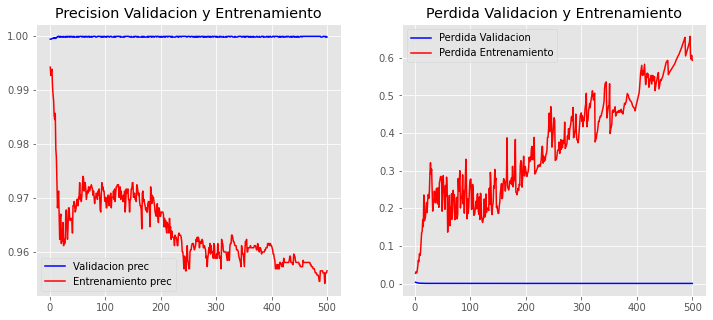

In [36]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') # 

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Validacion prec')
    plt.plot(x, val_acc, 'r', label='Entrenamiento prec')
    plt.title('Precision Validacion y Entrenamiento')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Perdida Validacion')
    plt.plot(x, val_loss, 'r', label='Perdida Entrenamiento')
    plt.title('Perdida Validacion y Entrenamiento')
    plt.legend()
    plt.show()
plot_history(history)

##P5.evaluar el modelo (presición)

In [38]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Precisión Prueba: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Precisión Entrenamiento:  {:.4f}".format(accuracy))

Precisión Prueba: 0.9999
Precisión Entrenamiento:  0.9566


##P6. haciendo predicciones

In [58]:
oracion = ['I love spontaneous road trips']
X_prueba = vectorizerNew.transform(oracion)  #convertimos la oración al array del bagword

#print('vector:',X_prueba[0].toarray())
predict=model.predict(X_prueba)
print(oracion,', The sentiment is :',predict)

['I love spontaneous road trips'] , The sentiment is : [[0.49544185]]


##p7.Exportar Modelo y Vocabulario


In [59]:
model.save('PLN_SENTIMENT.h5');